In [1]:
import os
import sys
from collections import OrderedDict
sys.path.append("../..")
import spatialpy
spatialpy.__file__
import matplotlib.pyplot as plt
import numpy
%load_ext autoreload
%autoreload 2

In [2]:
class Teleport(spatialpy.BoundaryCondition):
    def expression(self):
        return """
        if(me->x[0] > system->xhi){
            me->x[0] = system->xlo + 0.55;
        }
        me->x[2] = 0;
        me->rho = 250.0;
        """

In [3]:
class HardFloor(spatialpy.BoundaryCondition):
    def expression(self):
        return """
        if(me->x[1] < 0.4){
            me->x[1] = 0.5;
            me->v[1] = 0.0;
        }
        """

In [4]:
class HardWall(spatialpy.BoundaryCondition):
    def expression(self):
        return """
        if(me->x[0] < 1){
            me->x[0] = system->xlo + 0.5;
            me->v[1] = 0.0;
        }
        """

In [5]:
class weir(spatialpy.Model):
    def __init__(self, model_name="weir"):
        spatialpy.Model.__init__(self, model_name)

        xmax = 35.1
        ymax = 10.1

        # Construct mesh for backward facing step
        self.domain = spatialpy.Domain(0, xlim=(0,xmax), ylim=(0,ymax), zlim=(0,0), gravity=[0,-1,0])
        for x in numpy.arange(start=0, stop=xmax, step=0.2):
            for y in numpy.arange(start=0, stop=ymax, step=0.2):
                # Top and bottom
                if y == 0 or y == 10:
                    self.domain.add_point([x,y,0], type=1, mass=10.0, vol=1.0, nu=1.0, fixed=True)
                # Water
                elif y > 1.5 and y < 8 and x > 1.5 and x < 8:
                    self.domain.add_point([x,y,0], type=2, mass=10.0, vol=1.0, nu=1.0, fixed=False)
                # Step
                elif x >= 10 and x <= 15 and y > 0 and y < 5:
                    self.domain.add_point([x,y,0], type=1, mass=10.0, vol=1.0, nu=1.0, fixed=True)
                # Walls 
                elif x == 0 or x == 35:
                    self.domain.add_point([x,y,0], type=1, mass=10.0, vol=1.0, nu=1.0, fixed=True)


        # Teleport particles back to start to simulate flow
        self.add_boundary_condition(Teleport())
        self.add_boundary_condition(HardFloor())
        
        self.staticDomain = False

        # Define time parameters
        self.timestep_size = 1e-3  # timestep size
        #self.num_timesteps = 50000    # number of timesteps
        self.num_timesteps = 200000    # number of timesteps
        self.output_freq = 400      # frequency of outputting results

In [6]:
model = weir()

In [7]:
from spatialpy import Solver
sol = Solver(model, debug_level=0)
sol.compile()

In [8]:
%time result = sol.run()

CPU times: user 73.7 ms, sys: 39.2 ms, total: 113 ms
Wall time: 1h 14min


In [9]:
def mpl_plot_property(t_ndx=0):
        import matplotlib.pyplot as plt
        
        points, data = result.read_step(t_ndx)

        d = data["type"]

        plt.figure(figsize=(6.4, 4.8))
        plt.scatter(points[:,0],points[:,1], c=d)
        plt.axis('scaled')
        #plt.colorbar()
        #plt.title("title")
        plt.grid(linestyle='', linewidth=1)
        plt.plot()
        return

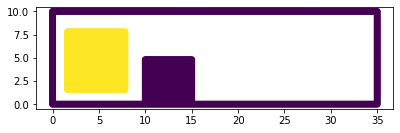

In [10]:
mpl_plot_property(0)

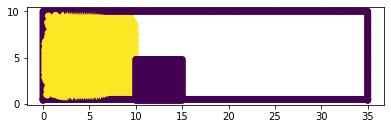

In [11]:
mpl_plot_property(1)

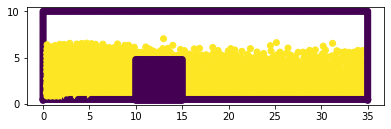

In [12]:
mpl_plot_property(500)